There was a problem due the lack of memory, the strategy was slice the work, therefore there are cells that belong to the roundabout pipeline

In [10]:
# img_labels & img_list - completed path to file
PATH_TO_LABELS_FILE = "../data/output_dataset/img_labels"
PATH_TO_PATHS_FILE = "../data/output_dataset/img_list"

# output convnet files path
PATH_TO_OUTPUT = "../data/output_convnet/Inception"

img_labels = []
img_list = []

with open(PATH_TO_LABELS_FILE,'r') as f_img_labels:
    for line in f_img_labels:
        img_labels.append(line[:-1]) 

with open(PATH_TO_PATHS_FILE,'r') as f_img_list:
    for line in f_img_list:
        img_list.append("../data/"+line[:-1]) # para eliminar el retorno de carro

In [7]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras import backend as K
from keras.optimizers import SGD
from keras.applications.inception_v3 import preprocess_input
import time
import numpy as np
from sys import getsizeof

In [3]:
input_tensor = Input(shape=(150, 150, 3))
base_model = InceptionV3(weights='imagenet', include_top=False,input_tensor=input_tensor)

In [4]:
# the top layer it is not like this one
# https://github.com/fchollet/deep-learning-models/blob/master/inception_v3.py#L342
x = base_model.output

# check them out
x = GlobalAveragePooling2D()(x)
x = Dense(4096, activation= None, name="fc1")(x)

predictions = Dense(8, activation='softmax')(x)

In [5]:
df_model = Model(inputs=base_model.input, outputs=predictions)
df_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

In [ ]:
# deep_features=4096

# high quality GPU
# dfmap = np.empty((len(img_list),deep_features))
# dfmap = np.empty((20,deep_features))

# low quality GPU
# dfmap_1 = np.empty((len(img_list)//2,deep_features))
# dfmap_2 = np.empty((len(img_list)//2,deep_features))
# dfmap_1 = np.empty((10,deep_features))
# dfmap_2 = np.empty((10,deep_features))

In [8]:
def dfmap_calc(img_list):
    
    deep_features=4096
    dfmap = np.empty((len(img_list),deep_features))
    
    for index, img_path in enumerate(img_list):

        inception_layer = Model(input=df_model.input, output=df_model.get_layer('fc1').output)

        # img preprocessing
        img = image.load_img(img_path, target_size=(299, 299), interpolation='lanczos')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # model predict
        x = inception_layer.predict(x)

        dfmap[index,:] = np.squeeze(x, axis=0)

    return dfmap

In [9]:
'''
in case of low quality GPU the aforementioned function has to be called twice 
or (4 times of whatever the number of slices) 
''' 
# import pickle

# ti_dfmap = time.time()

# dfmap_1 = dfmap_calc(img_list[:2500])

# tf_dfmap = time.time()    
# tt_dfmap = tf_dfmap - ti_dfmap
# print(time.strftime("%H:%M:%S", time.gmtime(tt_dfmap)))
# pickle.dump(dfmap_1, open('../data/output_convnet/inception_dfmap_1_pickle', 'wb'))

# dfmap_1.shape

# ti_dfmap = time.time()

# dfmap_2 = dfmap_calc(img_list[2500:])

# tf_dfmap = time.time()    
# tt_dfmap = tf_dfmap - ti_dfmap
# print(time.strftime("%H:%M:%S", time.gmtime(tt_dfmap)))
# pickle.dump(dfmap_2, open('../data/output_convnet/inception_dfmap_2_pickle', 'wb'))

# dfmap_2.shape

'\nin case of low quality GPU the aforementioned function has to be called twice \nor (4 times of whatever the number of slices) \n'

In [20]:
# done in two runs (given the memmory overload)
import os
import pickle

DF_MAP_1 = "inception_dfmap_1_pickle"
DF_MAP_2 = "inception_dfmap_2_pickle"


features_1 = pickle.load(open(os.path.join(PATH_TO_OUTPUT,DF_MAP_1),'rb'))
features_2 = pickle.load(open(os.path.join(PATH_TO_OUTPUT,DF_MAP_2),'rb'))

dfmap = np.append(features_1,features_2, axis=0)
pickle.dump(dfmap, open('../data/output_convnet/Inception/inception_dfmap_no_relU_pickle', 'wb'))
print("Tamaño en memoria de la matriz de características profundas: {0:.2f}Mb".format(getsizeof(dfmap)/float(1<<20)))

Tamaño en memoria de la matriz de características profundas: 156.25Mb


In [17]:
# checking the output with relu funct
dfmap

array([[ 0.35270447, -0.16462716, -1.15121675, ..., -0.22561511,
        -0.35752204, -0.2111565 ],
       [-0.03728645, -0.56002754, -0.43476558, ..., -0.4297373 ,
        -0.08391592, -0.44074461],
       [ 0.06060593,  0.08435172, -0.72759068, ..., -0.35703743,
         0.15956526,  0.25923416],
       ..., 
       [-0.07154811, -0.5647608 , -0.7619347 , ..., -0.16484213,
         0.15271489,  0.08950951],
       [-0.06565799, -0.51118308, -0.32295817, ..., -0.16710564,
         0.17676857, -0.11926451],
       [-0.07499143, -0.5802123 , -0.70561898, ..., -0.22710136,
         0.39600754,  0.02783351]])

Original Data no relU
    * file 156 Mb (around)
    * time 11' calcs // 0'' file (around)
    * deep features 4096
       
Original Data no relU with pca
    * file 8 Mb (around)
    * time 51'' calcs // 2'' file (around)
    * pca features 200 (aprox)


In [36]:
PATH_TO_LABELS_FILE = "../data/output_dataset"
LABELS = "img_labels"

PATH_TO_DF = "../data/output_convnet/Inception"
DF_MAP = "inception_dfmap_no_relU_pickle" # without activation function

dfmap = pickle.load(open(os.path.join(PATH_TO_DF,DF_MAP),'rb'))

In [26]:
import os
import pickle

labels = []

with open(os.path.join(PATH_TO_LABELS_FILE,LABELS),'r') as f_img_labels:
    for line in f_img_labels:
        labels.append(line[:-1])

features = pickle.load(open(os.path.join(PATH_TO_DF,DF_MAP),'rb'))

In [28]:
features_arr = np.array(features)
labels_arr = np.array(labels)

In [29]:
print("Deep features - deep feature map")
print()
print("Structure dims: {0:d} x {1:d}".format(features_arr.shape[0], features_arr.shape[1]))
print()
print("N of deep features arrays (images): ", features_arr.shape[0])
print()
print("N of deep features: ",features_arr.shape[1])
print()
print(features_arr) # array with deep features
print()
print()
print("Image's labels")
print()
print("Structure: ", type(labels_arr))
print()
print("Nº of image labels (images): ", len(labels_arr))
print()
print(labels_arr) # img's label

features_arr = features_arr.T # n x m matrix!

Deep features - deep feature map

Structure dims: 5000 x 4096

N of deep features arrays (images):  5000

N of deep features:  4096

[[ 0.35270447 -0.16462716 -1.15121675 ..., -0.22561511 -0.35752204
  -0.2111565 ]
 [-0.03728645 -0.56002754 -0.43476558 ..., -0.4297373  -0.08391592
  -0.44074461]
 [ 0.06060593  0.08435172 -0.72759068 ..., -0.35703743  0.15956526
   0.25923416]
 ..., 
 [-0.07154811 -0.5647608  -0.7619347  ..., -0.16484213  0.15271489
   0.08950951]
 [-0.06565799 -0.51118308 -0.32295817 ..., -0.16710564  0.17676857
  -0.11926451]
 [-0.07499143 -0.5802123  -0.70561898 ..., -0.22710136  0.39600754
   0.02783351]]


Image's labels

Structure:  <class 'numpy.ndarray'>

Nº of image labels (images):  5000

['01_TUMOR' '01_TUMOR' '01_TUMOR' ..., '08_EMPTY' '08_EMPTY' '08_EMPTY']


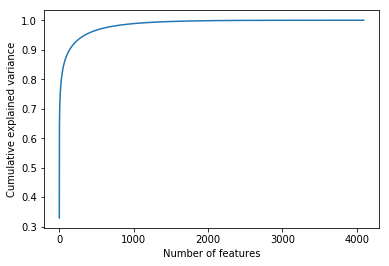

00:00:45


In [30]:
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline


ti_pca = time.time()

features_model_pca = PCA().fit(features_arr) # model

# plot
plt.plot(np.cumsum(features_model_pca.explained_variance_ratio_))
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')

plt.savefig(os.path.join(PATH_TO_DF, "inception_pca.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb
plt.show()


tf_pca = time.time()
tt_pca = tf_pca - ti_pca
print(time.strftime("%H:%M:%S", time.gmtime(tt_pca)))

In [31]:
# arange() does not work properly?

for i in np.arange(0.7,1,0.05):
    print("With %d features we get %f of cumulative explicative variance." % \
          (np.argmax(features_model_pca.explained_variance_ratio_.cumsum() > i), i))

With 6 features we get 0.700000 of cumulative explicative variance.
With 13 features we get 0.750000 of cumulative explicative variance.
With 28 features we get 0.800000 of cumulative explicative variance.
With 61 features we get 0.850000 of cumulative explicative variance.
With 139 features we get 0.900000 of cumulative explicative variance.
With 347 features we get 0.950000 of cumulative explicative variance.
With 0 features we get 1.000000 of cumulative explicative variance.


In [32]:
ti_pca = time.time()

features_model_pca = PCA(n_components=400) # fixed number of features 95%
features_model_pca.fit(features_arr)


tf_pca = time.time()
tt_pca = tf_pca - ti_pca
print(time.strftime("%H:%M:%S", time.gmtime(tt_pca)))

00:00:03


In [33]:
pickle.dump(features_model_pca.components_.T,\
            open(os.path.join(PATH_TO_DF,"inception_dfmap_no_relU_pca_pickle"), 'wb')) # without relU

Data no relU  no pca (time - acc)
    * SVM -> t = 6'24'' - 89.56%
    * DCT -> t = 2'37'' - 73.06%
    * RFC -> t = 18'' - 83.19%
       
Data no relU pca
    * SVM -> t = 7'' - 89.36%
    * DCT -> t = 7'' - 73.29%
    * RFC -> t = 3'' - 76.68%

In [37]:
DF_MAP = "inception_dfmap_no_relU_pickle" # original data no relU no pca
DF_MAP_pca = "inception_dfmap_no_relU_pca_pickle" # original data no relU with pca

In [38]:
features = pickle.load(open(os.path.join(PATH_TO_DF,DF_MAP),'rb'))
features_pca = pickle.load(open(os.path.join(PATH_TO_DF,DF_MAP_pca),'rb'))

In [40]:
features_arr = np.array(features)
features_arr_pca = np.array(features_pca)

labels_arr = np.array(img_labels)

print("Deep features - deep feature map")
print()
print("Structure dims: {0:d} x {1:d}".format(features_arr.shape[0], features_arr.shape[1]))
print()
print("N of deep features arrays (images): ", features_arr.shape[0])
print()
print("N of deep features: ",features_arr.shape[1])
print()
print(features_arr) # array with deep features
print()
print()
print("Deep features PCA- deep feature map")
print()
print("Structure dims: {0:d} x {1:d}".format(features_arr_pca.shape[0], features_arr_pca.shape[1]))
print()
print("N of deep features arrays (images): ", features_arr_pca.shape[0])
print()
print("N of deep features: ",features_arr_pca.shape[1])
print()
print(features_arr_pca) # array with deep features
print()
print()
print("Image's labels")
print()
print("Structure: ", type(labels_arr))
print()
print("Nº of image labels (images): ", len(labels_arr))
print()
print(labels_arr) # img's label

Deep features - deep feature map

Structure dims: 5000 x 4096

N of deep features arrays (images):  5000

N of deep features:  4096

[[ 0.35270447 -0.16462716 -1.15121675 ..., -0.22561511 -0.35752204
  -0.2111565 ]
 [-0.03728645 -0.56002754 -0.43476558 ..., -0.4297373  -0.08391592
  -0.44074461]
 [ 0.06060593  0.08435172 -0.72759068 ..., -0.35703743  0.15956526
   0.25923416]
 ..., 
 [-0.07154811 -0.5647608  -0.7619347  ..., -0.16484213  0.15271489
   0.08950951]
 [-0.06565799 -0.51118308 -0.32295817 ..., -0.16710564  0.17676857
  -0.11926451]
 [-0.07499143 -0.5802123  -0.70561898 ..., -0.22710136  0.39600754
   0.02783351]]


Deep features PCA- deep feature map

Structure dims: 5000 x 400

N of deep features arrays (images):  5000

N of deep features:  400

[[ 0.02307557 -0.00023592  0.0001682  ...,  0.02660147 -0.02710419
   0.00877769]
 [ 0.01965368  0.00018907  0.00090791 ...,  0.00594386 -0.01268166
  -0.00437931]
 [ 0.02048399 -0.00038007 -0.00087924 ...,  0.01422597  0.0146053
 

In [41]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
import time


cv_skf = StratifiedKFold(n_splits=10, shuffle=False, random_state=42)
# cv_kf = KFold(n_splits=5, shuffle=False, random_state=42)

# svm
SVM = LinearSVC()

ti_svm = time.time()

# data -> original dfmap no pca
scores = cross_val_score(SVM, features_arr, labels_arr, cv=cv_skf, n_jobs = -1)
# conf matrix
y_pred = cross_val_predict(SVM,features_arr, labels_arr,cv=cv_skf, n_jobs = -1)
conf_mat = confusion_matrix(labels_arr,y_pred)

tf_svm = time.time()
tt_svm = tf_svm - ti_svm


ti_svm_pca = time.time()

# data -> original dfmap pca
scores_pca = cross_val_score(SVM, features_arr_pca, labels_arr, cv=cv_skf, n_jobs = -1)
# conf matrix
y_pred_pca = cross_val_predict(SVM,features_arr_pca, labels_arr,cv=cv_skf, n_jobs = -1)
conf_mat_pca = confusion_matrix(labels_arr,y_pred_pca)

tf_svm_pca = time.time()
tt_svm_pca = tf_svm_pca - ti_svm_pca

In [42]:
# calc time
print(time.strftime("%H:%M:%S", time.gmtime(tt_svm))) # no pca
print(time.strftime("%H:%M:%S", time.gmtime(tt_svm_pca))) # pca

00:03:26
00:00:11


In [43]:
print("Feature map sin reducción de dimensiones")
print()

for i, score in enumerate(scores):
    print("acc fold nº {0:d}: {1:.2f}".format(i+1,score*100))
    
print()
print("media obtenida: {0:.2f}".format(scores.mean()*100))

print()
print()

Feature map sin reducción de dimensiones

acc fold nº 1: 95.04
acc fold nº 2: 94.05
acc fold nº 3: 94.64
acc fold nº 4: 93.06
acc fold nº 5: 93.45
acc fold nº 6: 94.15
acc fold nº 7: 93.35
acc fold nº 8: 93.15
acc fold nº 9: 93.55
acc fold nº 10: 93.95

media obtenida: 93.84




In [44]:
print("Feature map con reducción de dimensiones")
print()

for i, score in enumerate(scores_pca):
    print("acc fold nº {0:d}: {1:.2f}".format(i+1,score*100))
    
print()
print("media obtenida: {0:.2f}".format(scores_pca.mean()*100))

Feature map con reducción de dimensiones

acc fold nº 1: 93.45
acc fold nº 2: 92.46
acc fold nº 3: 93.25
acc fold nº 4: 93.65
acc fold nº 5: 94.25
acc fold nº 6: 94.56
acc fold nº 7: 92.54
acc fold nº 8: 90.93
acc fold nº 9: 92.54
acc fold nº 10: 94.15

media obtenida: 93.18


In [45]:
# confusion matrix
conf_mat

array([[592,   6,  23,   4,   0,   0,   0,   0],
       [  4, 562,  55,   4,   0,   0,   0,   0],
       [ 25,  63, 504,  33,   0,   0,   0,   0],
       [  4,   4,  44, 573,   0,   0,   0,   0],
       [  0,   0,   0,   0, 617,   2,   6,   0],
       [  0,   0,   0,   0,   5, 620,   0,   0],
       [  0,   0,   0,   0,   7,   0, 606,  12],
       [  0,   0,   0,   0,   2,   0,   5, 618]])

In [46]:
conf_mat_pca

array([[594,   4,  24,   3,   0,   0,   0,   0],
       [  2, 547,  72,   4,   0,   0,   0,   0],
       [ 35,  73, 488,  29,   0,   0,   0,   0],
       [  5,   6,  39, 575,   0,   0,   0,   0],
       [  0,   0,   0,   0, 615,   4,   6,   0],
       [  0,   0,   0,   0,   7, 618,   0,   0],
       [  0,   0,   0,   0,   8,   0, 601,  16],
       [  0,   0,   0,   0,   2,   0,   2, 621]])

In [47]:
# reference http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)

In [48]:
PATH_TO_IMG = "../data/input_dataset"
class_names = sorted([folder for folder in os.listdir(PATH_TO_IMG)
                      if os.path.isdir(os.path.join(PATH_TO_IMG, folder))])

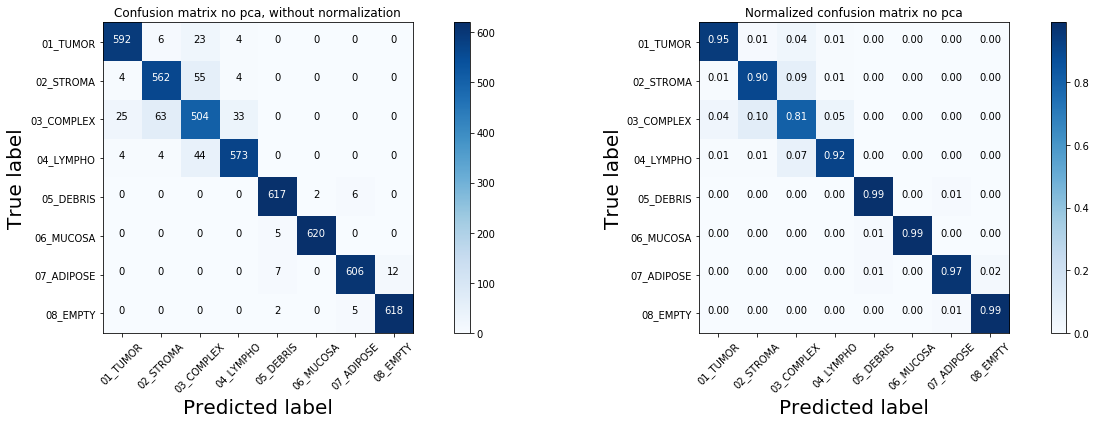

In [49]:
fig = plt.figure(figsize=(20, 6))


fig.add_subplot(1,2,1)
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix no pca, without normalization')

fig.add_subplot(1,2,2)
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix no pca')

plt.savefig(os.path.join(PATH_TO_DF, "inception_svm_no_pca.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()

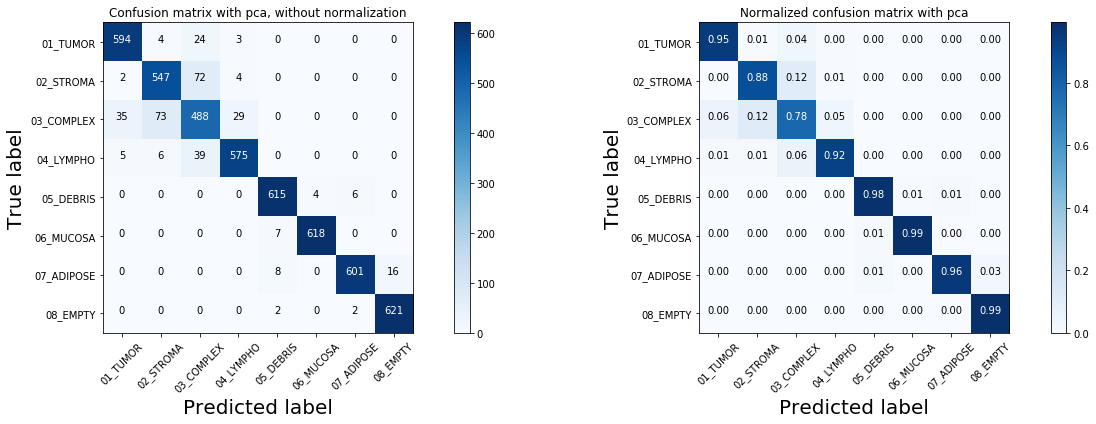

In [50]:
fig = plt.figure(figsize=(20, 6))


fig.add_subplot(1,2,1)
plot_confusion_matrix(conf_mat_pca, classes=class_names,
                      title='Confusion matrix with pca, without normalization')

fig.add_subplot(1,2,2)
plot_confusion_matrix(conf_mat_pca, classes=class_names, normalize=True,
                      title='Normalized confusion matrix with pca')

plt.savefig(os.path.join(PATH_TO_DF, "inception_svm_pca.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()

In [51]:
from sklearn.tree import DecisionTreeClassifier

# DTC
DTC = DecisionTreeClassifier()

ti_dtc = time.time()

# data -> original dfmap no pca
scores = cross_val_score(DTC, features_arr, labels_arr, cv=cv_skf, n_jobs = -1)
# conf matrix
y_pred = cross_val_predict(DTC,features_arr, labels_arr,cv=cv_skf, n_jobs = -1)
conf_mat = confusion_matrix(labels_arr,y_pred)

tf_dtc = time.time()
tt_dtc = tf_dtc - ti_dtc


ti_dtc_pca = time.time()

# data -> original dfmap pca
scores_pca = cross_val_score(DTC, features_arr_pca, labels_arr, cv=cv_skf, n_jobs = -1)
# conf matrix
y_pred_pca = cross_val_predict(DTC,features_arr_pca, labels_arr,cv=cv_skf, n_jobs = -1)
conf_mat_pca = confusion_matrix(labels_arr,y_pred_pca)

tf_dtc_pca = time.time()
tt_dtc_pca = tf_dtc_pca - ti_dtc_pca

In [52]:
# calc time
print(time.strftime("%H:%M:%S", time.gmtime(tt_dtc))) # no pca
print(time.strftime("%H:%M:%S", time.gmtime(tt_dtc_pca))) # pca

00:01:59
00:00:13


In [53]:
print("Feature map sin reducción de dimensiones")
print()

for i, score in enumerate(scores):
    print("acc fold nº {0:d}: {1:.2f}".format(i+1,score*100))
    
print()
print("media obtenida: {0:.2f}".format(scores.mean()*100))

print()
print()

Feature map sin reducción de dimensiones

acc fold nº 1: 80.36
acc fold nº 2: 78.97
acc fold nº 3: 80.75
acc fold nº 4: 79.56
acc fold nº 5: 81.75
acc fold nº 6: 79.64
acc fold nº 7: 78.02
acc fold nº 8: 79.84
acc fold nº 9: 78.43
acc fold nº 10: 77.82

media obtenida: 79.51




In [54]:
print("Feature map con reducción de dimensiones")
print()

for i, score in enumerate(scores_pca):
    print("acc fold nº {0:d}: {1:.2f}".format(i+1,score*100))
    
print()
print("media obtenida: {0:.2f}".format(scores_pca.mean()*100))

Feature map con reducción de dimensiones

acc fold nº 1: 82.94
acc fold nº 2: 81.55
acc fold nº 3: 83.73
acc fold nº 4: 82.74
acc fold nº 5: 83.93
acc fold nº 6: 84.48
acc fold nº 7: 82.66
acc fold nº 8: 82.46
acc fold nº 9: 80.65
acc fold nº 10: 80.44

media obtenida: 82.56


In [55]:
# confusion matrix
conf_mat

array([[452,  43,  99,  31,   0,   0,   0,   0],
       [ 46, 427, 126,  24,   0,   1,   1,   0],
       [109, 109, 338,  68,   0,   0,   1,   0],
       [ 24,  16,  73, 511,   0,   0,   1,   0],
       [  1,   1,   0,   0, 520,  54,  45,   4],
       [  0,   0,   0,   0,  57, 561,   7,   0],
       [  1,   1,   0,   0,  24,   9, 566,  24],
       [  1,   0,   0,   0,   5,   0,  18, 601]])

In [56]:
conf_mat_pca

array([[478,  33,  90,  24,   0,   0,   0,   0],
       [ 43, 443, 123,  16,   0,   0,   0,   0],
       [ 77, 114, 350,  84,   0,   0,   0,   0],
       [ 15,  16,  85, 509,   0,   0,   0,   0],
       [  0,   0,   0,   0, 574,  33,  17,   1],
       [  0,   0,   0,   0,  41, 581,   3,   0],
       [  0,   0,   0,   0,  11,   2, 595,  17],
       [  0,   0,   0,   0,   3,   0,  24, 598]])

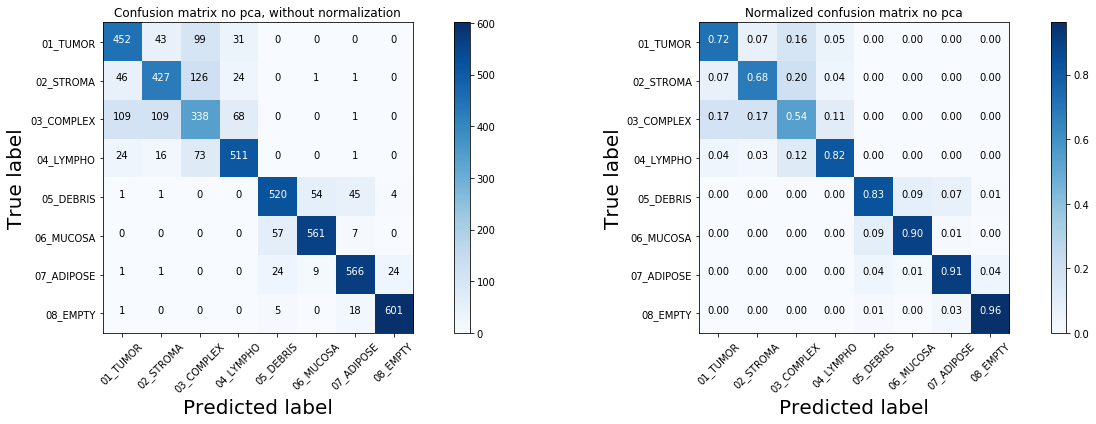

In [57]:
fig = plt.figure(figsize=(20, 6))


fig.add_subplot(1,2,1)
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix no pca, without normalization')

fig.add_subplot(1,2,2)
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix no pca')

plt.savefig(os.path.join(PATH_TO_DF, "inception_dtc_no_pca.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()

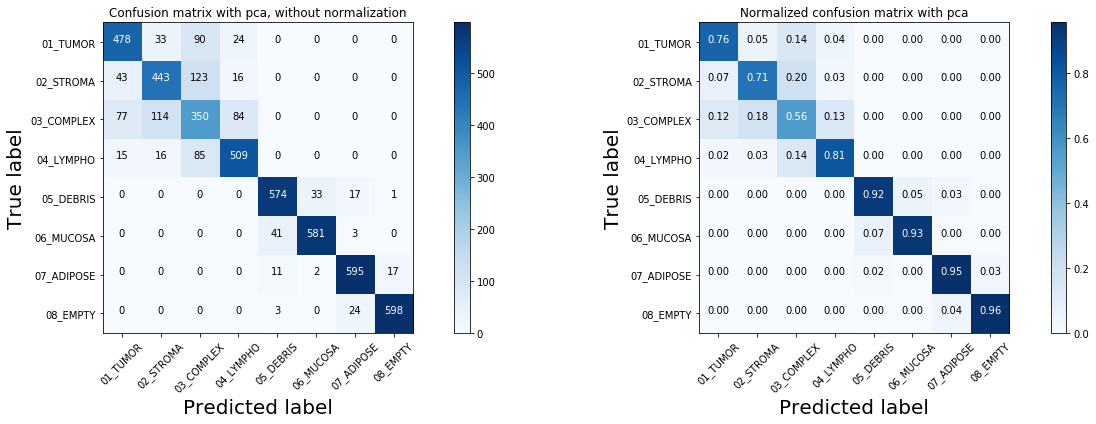

In [58]:
fig = plt.figure(figsize=(20, 6))


fig.add_subplot(1,2,1)
plot_confusion_matrix(conf_mat_pca, classes=class_names,
                      title='Confusion matrix with pca, without normalization')

fig.add_subplot(1,2,2)
plot_confusion_matrix(conf_mat_pca, classes=class_names, normalize=True,
                      title='Normalized confusion matrix with pca')

plt.savefig(os.path.join(PATH_TO_DF, "inception_dtc_pca.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()

In [59]:
from sklearn.ensemble import RandomForestClassifier

# RFC
RFC = RandomForestClassifier()

ti_rfc = time.time()

# data -> original dfmap no pca
scores = cross_val_score(RFC, features_arr, labels_arr, cv=cv_skf, n_jobs = -1)
# conf matrix
y_pred = cross_val_predict(RFC,features_arr, labels_arr,cv=cv_skf, n_jobs = -1)
conf_mat = confusion_matrix(labels_arr,y_pred)

tf_rfc = time.time()
tt_rfc = tf_rfc - ti_rfc


ti_rfc_pca = time.time()

# data -> original dfmap pca
scores_pca = cross_val_score(RFC, features_arr_pca, labels_arr, cv=cv_skf, n_jobs = -1)
# conf matrix
y_pred_pca = cross_val_predict(RFC,features_arr_pca, labels_arr,cv=cv_skf, n_jobs = -1)
conf_mat_pca = confusion_matrix(labels_arr,y_pred_pca)

tf_rfc_pca = time.time()
tt_rfc_pca = tf_rfc_pca - ti_rfc_pca

In [60]:
# calc time
print(time.strftime("%H:%M:%S", time.gmtime(tt_rfc))) # no pca
print(time.strftime("%H:%M:%S", time.gmtime(tt_rfc_pca))) # pca

00:00:15
00:00:04


In [61]:
print("Feature map sin reducción de dimensiones")
print()

for i, score in enumerate(scores):
    print("acc fold nº {0:d}: {1:.2f}".format(i+1,score*100))
    
print()
print("media obtenida: {0:.2f}".format(scores.mean()*100))

print()
print()

Feature map sin reducción de dimensiones

acc fold nº 1: 89.48
acc fold nº 2: 87.30
acc fold nº 3: 87.70
acc fold nº 4: 86.51
acc fold nº 5: 87.10
acc fold nº 6: 86.49
acc fold nº 7: 88.51
acc fold nº 8: 86.90
acc fold nº 9: 87.70
acc fold nº 10: 86.49

media obtenida: 87.42




In [62]:
print("Feature map con reducción de dimensiones")
print()

for i, score in enumerate(scores_pca):
    print("acc fold nº {0:d}: {1:.2f}".format(i+1,score*100))
    
print()
print("media obtenida: {0:.2f}".format(scores_pca.mean()*100))

Feature map con reducción de dimensiones

acc fold nº 1: 88.10
acc fold nº 2: 83.33
acc fold nº 3: 85.91
acc fold nº 4: 83.73
acc fold nº 5: 83.73
acc fold nº 6: 84.27
acc fold nº 7: 82.66
acc fold nº 8: 84.88
acc fold nº 9: 83.27
acc fold nº 10: 83.06

media obtenida: 84.29


In [63]:
# confusion matrix
conf_mat

array([[558,  21,  40,   6,   0,   0,   0,   0],
       [ 29, 516,  72,   8,   0,   0,   0,   0],
       [ 76, 132, 383,  34,   0,   0,   0,   0],
       [ 10,  10,  86, 519,   0,   0,   0,   0],
       [  0,   0,   0,   0, 605,  11,   9,   0],
       [  0,   0,   0,   0,  28, 597,   0,   0],
       [  0,   0,   0,   0,  22,   2, 588,  13],
       [  0,   0,   0,   0,   5,   0,  15, 605]])

In [64]:
conf_mat_pca

array([[523,  28,  56,  18,   0,   0,   0,   0],
       [ 51, 484,  76,  14,   0,   0,   0,   0],
       [112, 143, 322,  48,   0,   0,   0,   0],
       [ 21,  17,  72, 515,   0,   0,   0,   0],
       [  0,   0,   0,   0, 600,  14,  11,   0],
       [  0,   0,   0,   0,  42, 579,   4,   0],
       [  0,   0,   0,   0,  20,   2, 587,  16],
       [  0,   0,   0,   0,   5,   3,  12, 605]])

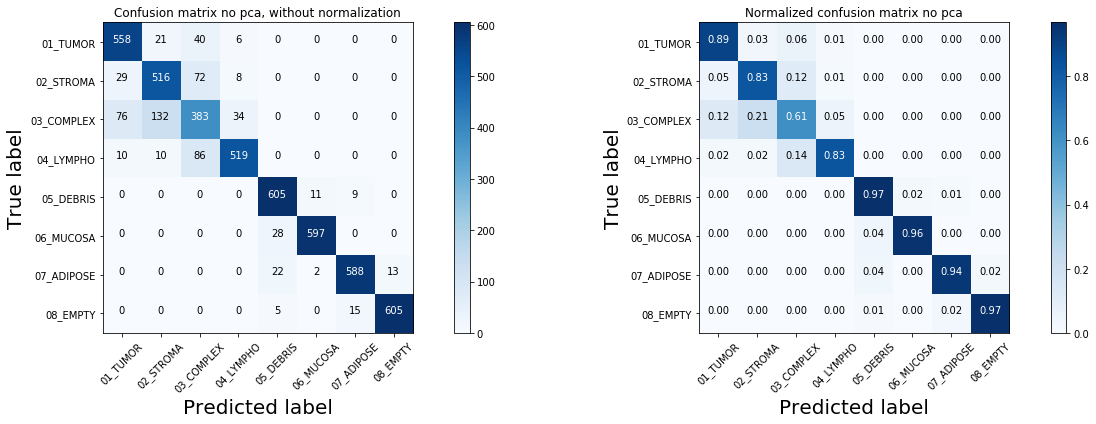

In [65]:
fig = plt.figure(figsize=(20, 6))


fig.add_subplot(1,2,1)
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix no pca, without normalization')

fig.add_subplot(1,2,2)
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix no pca')

plt.savefig(os.path.join(PATH_TO_DF, "inception_rfc_no_pca.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()

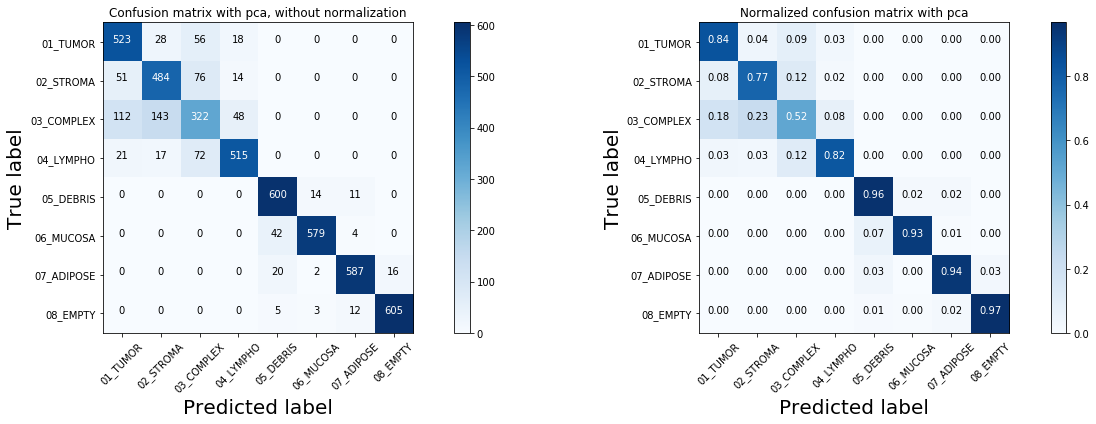

In [66]:
fig = plt.figure(figsize=(20, 6))


fig.add_subplot(1,2,1)
plot_confusion_matrix(conf_mat_pca, classes=class_names,
                      title='Confusion matrix with pca, without normalization')

fig.add_subplot(1,2,2)
plot_confusion_matrix(conf_mat_pca, classes=class_names, normalize=True,
                      title='Normalized confusion matrix with pca')

plt.savefig(os.path.join(PATH_TO_DF, "inception_rfc_pca.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()